DATA PREPROCESSING

In [27]:
from google.colab import files
uploaded = files.upload()



Saving 2d_materials_data.csv to 2d_materials_data (2).csv


In [28]:
import pandas as pd
import numpy as np
df = pd.read_csv("2d_materials_data.csv")
# OR use your actual filename

print(df.shape)
df.head()


(3129, 10)


,dosef,energy,natom,mass,fmax,smax,hform,volume,gap_nosoc,gap
0,0.0,-16.112529,4,247.734400,0.009337,0.000149,-0.046132,327.286639,0.159791,0.164045
1,0.0,-13.581981,4,279.856400,0.007039,0.000079,0.063505,380.909858,0.967953,0.961595
2,0.0,-12.556373,4,373.678400,0.009621,0.000034,0.022407,401.441237,0.869507,0.750715
3,0.0,-11.852202,4,470.936400,0.007429,0.000021,0.059449,459.020808,0.663121,0.478298
4,0.0,-16.546603,4,425.931138,0.005010,0.000360,-0.009651,322.649929,0.165582,0.175493


In [29]:
print(df.columns.tolist())


['dosef', 'energy', 'natom', 'mass', 'fmax', 'smax', 'hform', 'volume', 'gap_nosoc', 'gap']


In [30]:
# Drop rows with missing SOC or non-SOC bandgaps
df = df.dropna(subset=["gap", "gap_nosoc"])

# Remove non-physical values
df = df[(df["gap"] > 0) & (df["gap_nosoc"] > 0)]

print("After basic cleaning:", df.shape)



After basic cleaning: (901, 10)


In [31]:
# TMDC SOC bandgap window (in eV)
LOW_BG = 0.8
HIGH_BG = 2.5

df = df[(df["gap"] >= LOW_BG) & (df["gap"] <= HIGH_BG)]

print("After TMDC bandgap filtering:", df.shape)


After TMDC bandgap filtering: (415, 10)


MODEL TRAINING (GBDT,RF,XGB)

In [32]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor



In [22]:
# Model A (physics-assisted)
features_A = [
    'dosef', 'energy', 'mass',
    'hform', 'volume', 'gap_nosoc'
]

# Model B (baseline)
features_B = [
    'dosef', 'energy', 'mass',
    'hform', 'volume'
]

X_A = df[features_A]
X_B = df[features_B]



In [33]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)



In [34]:
X_A = df[features_A]
X_B = df[features_B]
y = df['gap']

print(X_A.shape, X_B.shape, y.shape)


(415, 6) (415, 5) (415,)


In [35]:
rf_base = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf_A = clone(rf_base)
rf_B = clone(rf_base)

rmse_rf_A = -cross_val_score(
    rf_A, X_A, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

rmse_rf_B = -cross_val_score(
    rf_B, X_B, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)



In [36]:
gbdt = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    random_state=42
)

rmse_gbdt_A = -cross_val_score(
    gbdt, X_A, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

rmse_gbdt_B = -cross_val_score(
    gbdt, X_B, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)


In [37]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

rmse_xgb_A = -cross_val_score(
    xgb, X_A, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

rmse_xgb_B = -cross_val_score(
    xgb, X_B, y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)


In [38]:
results = pd.DataFrame({
    "Model": ["RF", "GBDT", "XGB"],
    "Model_A_RMSE": [
        rmse_rf_A.mean(),
        rmse_gbdt_A.mean(),
        rmse_xgb_A.mean()
    ],
    "Model_B_RMSE": [
        rmse_rf_B.mean(),
        rmse_gbdt_B.mean(),
        rmse_xgb_B.mean()
    ]
})




In [40]:
results_detailed = pd.DataFrame({
    "Model": ["Random Forest", "GBDT", "XGBoost"],

    "Model A RMSE (mean)": [
        rmse_rf_A.mean(),
        rmse_gbdt_A.mean(),
        rmse_xgb_A.mean()
    ],
    "Model A RMSE (std)": [
        rmse_rf_A.std(),
        rmse_gbdt_A.std(),
        rmse_xgb_A.std()
    ],

    "Model B RMSE (mean)": [
        rmse_rf_B.mean(),
        rmse_gbdt_B.mean(),
        rmse_xgb_B.mean()
    ],
    "Model B RMSE (std)": [
        rmse_rf_B.std(),
        rmse_gbdt_B.std(),
        rmse_xgb_B.std()
    ]
})

results_detailed




,Model,Model A RMSE (mean),Model A RMSE (std),Model B RMSE (mean),Model B RMSE (std)
0,Random Forest,0.189887,0.014289,0.349350,0.020239
1,GBDT,0.160261,0.013162,0.351136,0.021296
2,XGBoost,0.168604,0.013959,0.347531,0.018331


In [41]:
results_detailed["RMSE Improvement (%)"] = (
    (results_detailed["Model B RMSE (mean)"]
     - results_detailed["Model A RMSE (mean)"])
    / results_detailed["Model B RMSE (mean)"]
) * 100

results_detailed


,Model,Model A RMSE (mean),Model A RMSE (std),Model B RMSE (mean),Model B RMSE (std),RMSE Improvement (%)
0,Random Forest,0.189887,0.014289,0.349350,0.020239,45.645632
1,GBDT,0.160261,0.013162,0.351136,0.021296,54.359217
2,XGBoost,0.168604,0.013959,0.347531,0.018331,51.485117


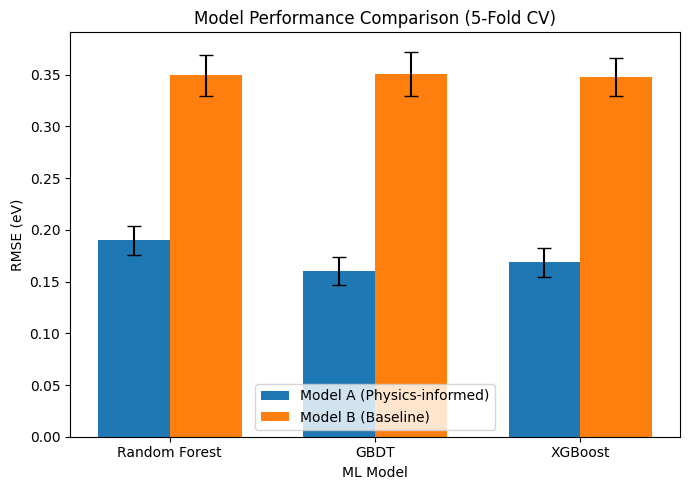

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(results_detailed["Model"]))
width = 0.35

plt.figure(figsize=(7,5))

plt.bar(
    x - width/2,
    results_detailed["Model A RMSE (mean)"],
    width,
    yerr=results_detailed["Model A RMSE (std)"],
    capsize=5,
    label="Model A (Physics-informed)"
)

plt.bar(
    x + width/2,
    results_detailed["Model B RMSE (mean)"],
    width,
    yerr=results_detailed["Model B RMSE (std)"],
    capsize=5,
    label="Model B (Baseline)"
)

plt.xticks(x, results_detailed["Model"])
plt.ylabel("RMSE (eV)")
plt.xlabel("ML Model")
plt.title("Model Performance Comparison (5-Fold CV)")
plt.legend()
plt.tight_layout()
plt.show()



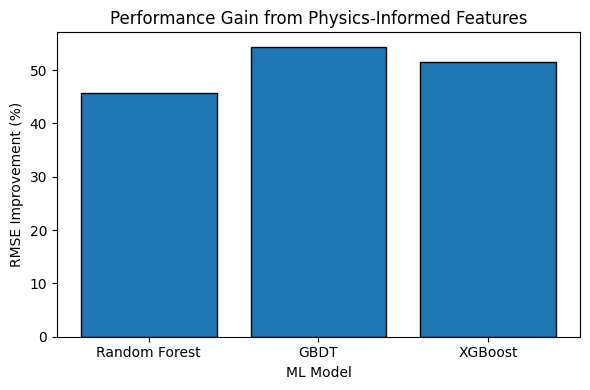

In [43]:
plt.figure(figsize=(6,4))

plt.bar(
    results_detailed["Model"],
    results_detailed["RMSE Improvement (%)"],
    edgecolor="black"
)

plt.ylabel("RMSE Improvement (%)")
plt.xlabel("ML Model")
plt.title("Performance Gain from Physics-Informed Features")
plt.tight_layout()
plt.show()


UNCERTAINTY ANALYSIS

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

def gbdt_uncertainty(X, y, n_models=50):
    preds = []
    for seed in range(n_models):
        model = GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=4,
            min_samples_split=5,
            min_samples_leaf=3,
            subsample=0.8,
            random_state=seed
        )
        model.fit(X, y)
        preds.append(model.predict(X))
    preds = np.array(preds)
    return preds.mean(axis=0), preds.std(axis=0)


In [45]:
mean_pred, std_pred = gbdt_uncertainty(X_A, y)

df["pred_mean"] = mean_pred
df["pred_uncertainty"] = std_pred

print("Mean uncertainty (eV):", std_pred.mean())
print("Median uncertainty (eV):", np.median(std_pred))

Mean uncertainty (eV): 0.005309266607621332
Median uncertainty (eV): 0.0051449736679444824


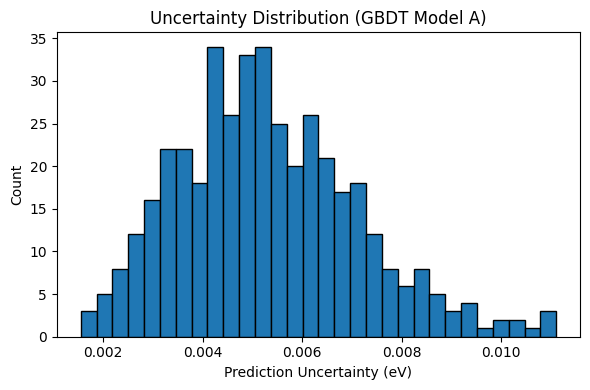

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(std_pred, bins=30, edgecolor="black")
plt.xlabel("Prediction Uncertainty (eV)")
plt.ylabel("Count")
plt.title("Uncertainty Distribution (GBDT Model A)")
plt.tight_layout()
plt.show()


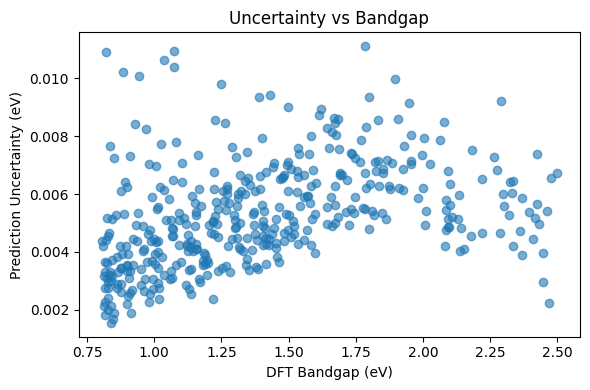

In [47]:
plt.figure(figsize=(6,4))
plt.scatter(df["gap"], std_pred, alpha=0.6)
plt.xlabel("DFT Bandgap (eV)")
plt.ylabel("Prediction Uncertainty (eV)")
plt.title("Uncertainty vs Bandgap")
plt.tight_layout()
plt.show()


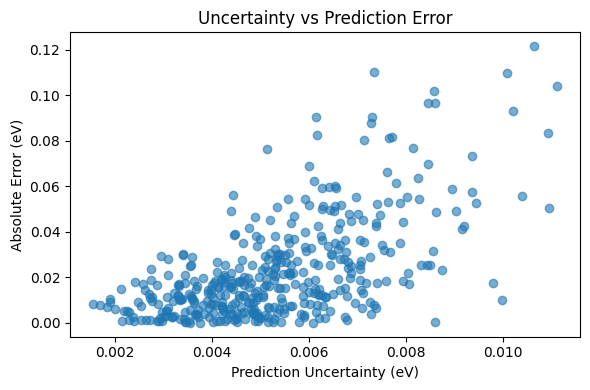

In [48]:
abs_error = np.abs(df["gap"] - mean_pred)

plt.figure(figsize=(6,4))
plt.scatter(std_pred, abs_error, alpha=0.6)
plt.xlabel("Prediction Uncertainty (eV)")
plt.ylabel("Absolute Error (eV)")
plt.title("Uncertainty vs Prediction Error")
plt.tight_layout()
plt.show()


ERROR ANALYSIS BY BANDGAP RANGE

In [49]:
import numpy as np

df["abs_error"] = np.abs(df["gap"] - df["pred_mean"])



In [50]:
import pandas as pd

bins = [0.8, 1.2, 1.6, 2.0, 2.5]
labels = ["0.8–1.2", "1.2–1.6", "1.6–2.0", "2.0–2.5"]

df["gap_bin"] = pd.cut(
    df["gap"],
    bins=bins,
    labels=labels
)



In [51]:
error_by_bin = df.groupby("gap_bin")["abs_error"].agg(
    mean_error="mean",
    std_error="std",
    count="count"
)

error_by_bin


/tmp/ipython-input-1273147986.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = df.groupby("gap_bin")["abs_error"].agg(


,mean_error,std_error,count
gap_bin,,,
0.8–1.2,0.021531,0.023834,162
1.2–1.6,0.023327,0.018853,131
1.6–2.0,0.027731,0.025792,69
2.0–2.5,0.019339,0.017204,53


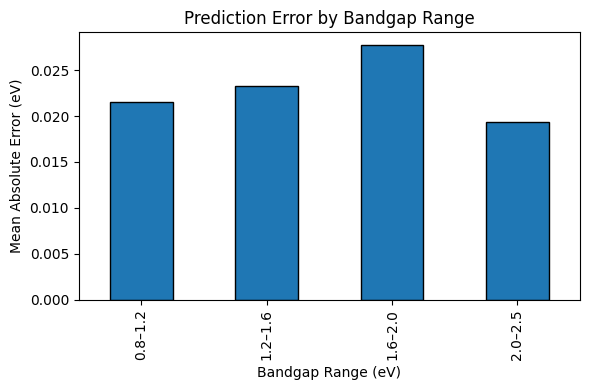

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

error_by_bin["mean_error"].plot(
    kind="bar",
    edgecolor="black",
    color="tab:blue"
)

plt.ylabel("Mean Absolute Error (eV)")
plt.xlabel("Bandgap Range (eV)")
plt.title("Prediction Error by Bandgap Range")

plt.tight_layout()
plt.show()

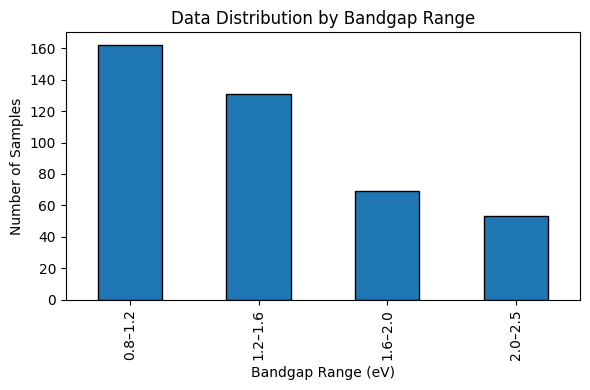

In [60]:
plt.figure(figsize=(6,4))
error_by_bin['count'].plot(kind="bar", edgecolor="black")
plt.ylabel("Number of Samples")
plt.xlabel("Bandgap Range (eV)")
plt.title("Data Distribution by Bandgap Range")
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE

In [65]:
import pandas as pd

fi = pd.DataFrame({
    "Feature": features_A,
    "GBDT": gbdt.feature_importances_,
    "RF": rf.feature_importances_,
    "XGB": xgb.feature_importances_
})

fi_norm = fi.copy()
fi_norm.iloc[:, 1:] = fi_norm.iloc[:, 1:].div(
    fi_norm.iloc[:, 1:].sum(axis=0),
    axis=1
)


<Figure size 800x500 with 0 Axes>

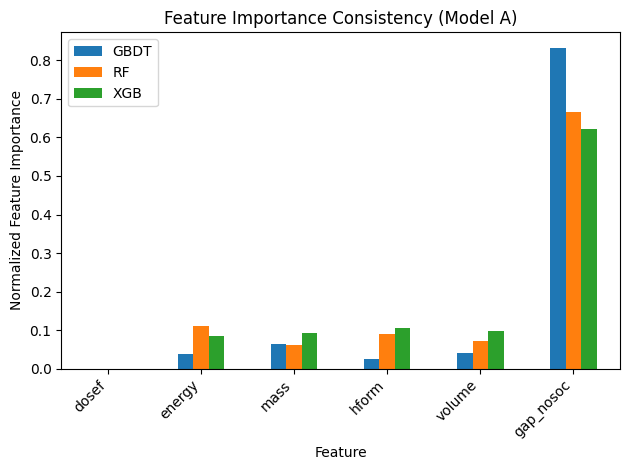

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

fi_norm.set_index("Feature").plot(kind="bar")

plt.ylabel("Normalized Feature Importance")
plt.title("Feature Importance Consistency (Model A)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()




In [67]:
rank_table = fi_norm.set_index("Feature").rank(ascending=False)
rank_table


,GBDT,RF,XGB
Feature,,,
dosef,6.0,6.0,6.0
energy,4.0,2.0,5.0
mass,2.0,5.0,4.0
hform,5.0,3.0,2.0
volume,3.0,4.0,3.0
gap_nosoc,1.0,1.0,1.0


PARITY PLOT

In [70]:
# True and predicted values
y_true = y
y_pred = gbdt.predict(X)


NameError: name 'X' is not defined

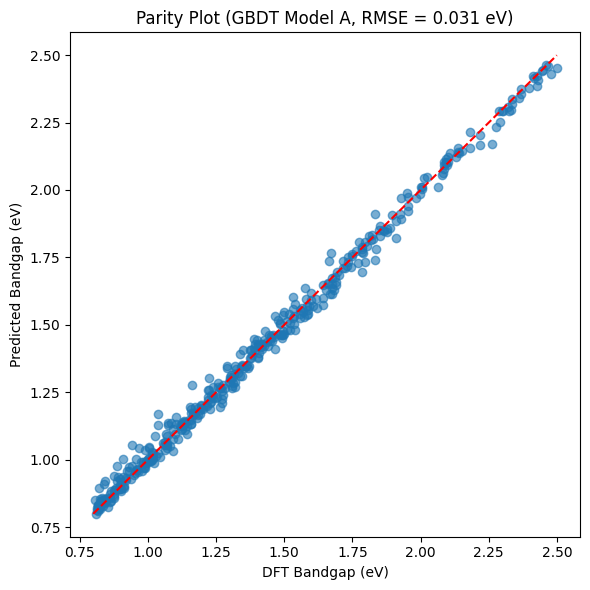

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib
import pandas as pd


X = df[features_A]
y = df["gap"]

y_true = y
y_pred = gbdt.predict(X)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.xlabel("DFT Bandgap (eV)")
plt.ylabel("Predicted Bandgap (eV)")
plt.title(f"Parity Plot (GBDT Model A, RMSE = {rmse:.3f} eV)")
plt.tight_layout()
plt.show()




LEARNING CURVE

In [72]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor


In [73]:
gbdt = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    random_state=42
)


In [74]:
train_sizes, train_scores, val_scores = learning_curve(
    gbdt,
    X,
    y_true,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring="neg_root_mean_squared_error",
    shuffle=True,
    random_state=42
)


In [75]:
train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)


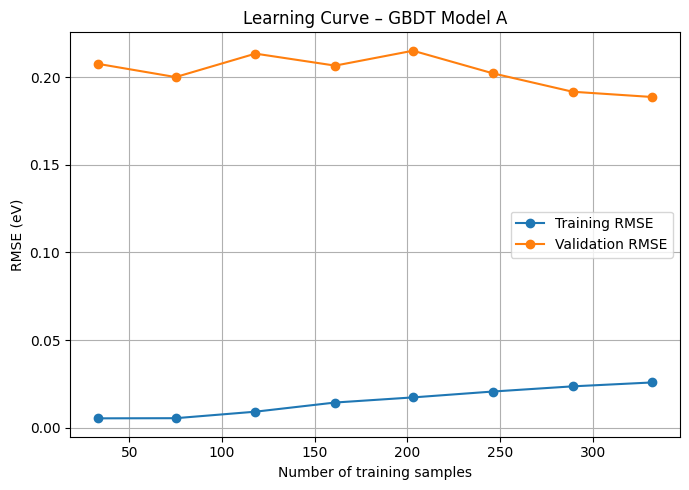

In [76]:
plt.figure(figsize=(7,5))

plt.plot(train_sizes, train_rmse, 'o-', label="Training RMSE")
plt.plot(train_sizes, val_rmse, 'o-', label="Validation RMSE")

plt.xlabel("Number of training samples")
plt.ylabel("RMSE (eV)")
plt.title("Learning Curve – GBDT Model A")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
